In [27]:
from utils import conv
from utils import NN2hidden as nn2
from utils import dataprepare as dp
from utils import Feature_extract as fe

import cv2
import math
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

In [28]:
def load_weights(filename):
    with open(filename, 'rb') as f:
        data = np.load(f)
        weights_hidden2_output = data['weights_hidden2_output']
        bias_hidden2_output = data['bias_hidden2_output']
        weights_hidden1_hidden2 = data['weights_hidden1_hidden2']
        bias_hidden1_hidden2 = data['bias_hidden1_hidden2']
        weights_input_hidden1 = data['weights_input_hidden1']
        bias_input_hidden1 = data['bias_input_hidden1']
    return weights_hidden2_output, bias_hidden2_output, weights_hidden1_hidden2, bias_hidden1_hidden2, weights_input_hidden1, bias_input_hidden1

In [4]:
# Load images and ground truth labels
images_path = 'patching_fix/patch_image'
feature_images_path = 'patching_fix/feature_extract'
ground_truths_path = 'patching_fix/patch_ground'

images_load = dp.load_images_from_folder(images_path)
feature_images_load = dp.load_images_from_folder(feature_images_path)
ground_truths = dp.load_ground_truth_from_folder(ground_truths_path)

In [5]:
feature_images_train = feature_images_load[:math.ceil(len(feature_images_load)*0.7)] 
image_label_train = ground_truths[:math.ceil(len(ground_truths)*0.7)]

image_test = images_load[math.ceil(len(images_load)*0.7):]
image_label_test = ground_truths[math.ceil(len(ground_truths)*0.7):]

In [6]:
# # Prepare data
# X_test, y_test = dp.prepare_data(image_test, image_label_test)
# # Normalize the features
# X__test_normalized = X_test / 255.0

In [29]:
# input_size = X__test_normalized.shape[0]
input_size = 3
hidden_size1 = 3  # neuron hidden layer 1
hidden_size2 = 2  # neuron hidden layer 2
output_size = 2  # 2 classes: vegetation and non-vegetation

In [30]:
# Load weights for testing
weights_hidden2_output, bias_hidden2_output, weights_hidden1_hidden2, bias_hidden1_hidden2, weights_input_hidden1, bias_input_hidden1 = load_weights("6. Bobot_skenario_6.npz")


# Initialize the neural network with the loaded weights
model_loaded = nn2.NeuralNetwork(input_size, hidden_size1, hidden_size2, output_size)
model_loaded.weights_hidden2_output = weights_hidden2_output
model_loaded.bias_hidden2_output = bias_hidden2_output
model_loaded.weights_hidden1_hidden2 = weights_hidden1_hidden2
model_loaded.bias_hidden1_hidden2 = bias_hidden1_hidden2
model_loaded.weights_input_hidden1 = weights_input_hidden1
model_loaded.bias_input_hidden1 = bias_input_hidden1

In [31]:
print('Bobot dan bias yang diload:')
print('Bobot hidden layer 1:\n', model_loaded.weights_input_hidden1)
print('Bias hidden layer 1:\n', model_loaded.bias_input_hidden1[0][0])
print('Bobot hidden layer 2:\n', model_loaded.weights_hidden1_hidden2)
print('Bias hidden layer 2:\n', model_loaded.bias_hidden1_hidden2[0][0])
print('Bobot output layer:\n', model_loaded.weights_hidden2_output)
print('Bias output layer:\n', model_loaded.bias_hidden2_output[0][0])

Bobot dan bias yang diload:
Bobot hidden layer 1:
 [[  9.82482718   9.90564083  10.54672675]
 [-12.61320665 -12.71202733 -13.54938776]
 [ -7.63166258  -7.70996419  -8.20904912]]
Bias hidden layer 1:
 -0.4651106399283047
Bobot hidden layer 2:
 [[-9.20212658 -8.95796672]
 [-9.26871999 -9.0637113 ]
 [-9.86473236 -9.80772181]]
Bias hidden layer 2:
 8.779761661187278
Bobot output layer:
 [[ 0.77480982 -0.77480982]
 [ 0.15134877 -0.15134877]]
Bias output layer:
 0.05433228622306542


In [8]:
TP = 0  # True Positives
FP = 0  # False Positives
FN = 0  # False Negatives
TN = 0  # True Negatives

# Loop over testing images
for i in range(len(image_test)):
    TPi = 0  # True Positives index
    FPi = 0  # False Positives index
    FNi = 0  # False Negatives index
    TNi = 0  # True Negatives index

    input_image = image_test[i]
    ground_truth = image_label_test[i]

    # Preprocess the input image
    input_image_reshaped = cv2.resize(input_image, (128, 128)) / 255.0
    features = input_image_reshaped.reshape(-1, 3)

    # Predict segmentation mask
    predicted_mask = model_loaded.forward(features)
    predicted_mask = predicted_mask.argmax(axis=1).reshape(128, 128)

    # Convert ground truth to binary mask for both vegetation and non-vegetation
    vegetation_ground_truth = np.logical_or(
        np.all(ground_truth == [0, 255, 255], axis=2),
        np.all(ground_truth == [0, 255, 0], axis=2)
    )
    
    # Calculate TP, FP, FN, TN for the current image
    for row in range(predicted_mask.shape[0]):
        for col in range(predicted_mask.shape[1]):
            if predicted_mask[row, col] == 1 and vegetation_ground_truth[row, col]:
                TPi += 1
                TP += 1
            elif predicted_mask[row, col] == 1 and not vegetation_ground_truth[row, col]:
                FPi += 1
                FP += 1
            elif predicted_mask[row, col] == 0 and vegetation_ground_truth[row, col]:
                FNi += 1
                FN += 1
            elif predicted_mask[row, col] == 0 and not vegetation_ground_truth[row, col]:
                TNi += 1
                TN += 1
    
    # Print the values for TP, FP, FN, TN for the current image
    print("Image {}: TP = {}, FP = {}, FN = {}, TN = {}".format(i+1, TPi, FPi, FNi, TNi))

Image 1: TP = 6, FP = 0, FN = 39, TN = 16339
Image 2: TP = 0, FP = 0, FN = 0, TN = 16384
Image 3: TP = 317, FP = 0, FN = 205, TN = 15862
Image 4: TP = 0, FP = 0, FN = 0, TN = 16384
Image 5: TP = 4, FP = 0, FN = 6, TN = 16374
Image 6: TP = 365, FP = 0, FN = 251, TN = 15768
Image 7: TP = 3425, FP = 0, FN = 2144, TN = 10815
Image 8: TP = 0, FP = 0, FN = 0, TN = 16384
Image 9: TP = 97, FP = 0, FN = 74, TN = 16213
Image 10: TP = 2891, FP = 1, FN = 6275, TN = 7217
Image 11: TP = 314, FP = 0, FN = 1350, TN = 14720
Image 12: TP = 3670, FP = 0, FN = 5261, TN = 7453
Image 13: TP = 56, FP = 0, FN = 170, TN = 16158
Image 14: TP = 230, FP = 49, FN = 167, TN = 15938
Image 15: TP = 2329, FP = 0, FN = 720, TN = 13335
Image 16: TP = 0, FP = 0, FN = 0, TN = 16384
Image 17: TP = 0, FP = 0, FN = 0, TN = 16384
Image 18: TP = 0, FP = 0, FN = 0, TN = 16384
Image 19: TP = 0, FP = 0, FN = 0, TN = 16384
Image 20: TP = 0, FP = 0, FN = 0, TN = 16384
Image 21: TP = 31, FP = 0, FN = 184, TN = 16169
Image 22: TP = 0

In [9]:
recall = TP / (TP + FN)
precision = TP / (TP + FP)
accuracy = (TP + TN) / (TP + FP + FN + TN)
f1_score = 2 * (precision * recall) / (precision + recall)
IoU = TP / (TP + FP + FN)

print('TP:', TP)
print('FP:', FP)
print('FN:', FN)
print('TN:', TN)

print()
print('Recall: {:.3f}'.format(recall))
print('Precision: {:.3f}'.format(precision))
print('Accuracy: {:.3f}'.format(accuracy))
print('F1 Score: {:.3f}'.format(f1_score))

print()
print("IoU Overall: {:.3f} ".format(IoU))

TP: 2445840
FP: 12599
FN: 2057132
TN: 7887117

Recall: 0.543
Precision: 0.995
Accuracy: 0.833
F1 Score: 0.703

IoU Overall: 0.542 


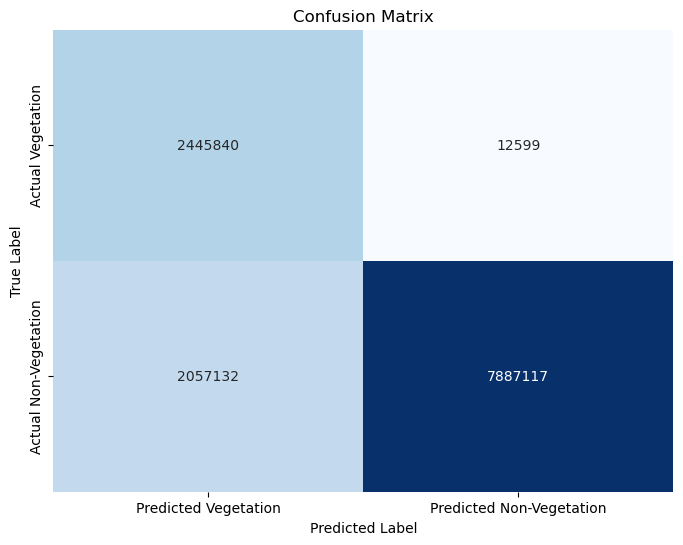

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
conf_matrix = np.array([[TP, FP],
                        [FN, TN]])

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Vegetation', 'Predicted Non-Vegetation'], 
            yticklabels=['Actual Vegetation', 'Actual Non-Vegetation'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [8]:
# Initialize lists for TP, FP, FN, and IoU
TP_vegetation = []
FP_vegetation = []
FN_vegetation = []
IoU_vegetation = []

TP_non_vegetation = []
FP_non_vegetation = []
FN_non_vegetation = []
IoU_non_vegetation = []

# Loop over testing images
for i in range(len(image_test)):
    input_image = image_test[i]
    ground_truth = image_label_test[i]

    # Preprocess the input image
    input_image_reshaped = cv2.resize(input_image, (128, 128)) / 255.0
    features = input_image_reshaped.reshape(-1, 3)

    # Predict segmentation mask
    predicted_mask = model_loaded.forward(features)
    predicted_mask = predicted_mask.argmax(axis=1).reshape(128, 128)

    # Convert ground truth to binary mask for both vegetation and non-vegetation
    vegetation_ground_truth = np.logical_or(
        np.all(ground_truth == [0, 255, 255], axis=2),
        np.all(ground_truth == [0, 255, 0], axis=2)
    )
    
    # Calculate TP, FP, FN counts for both vegetation and non-vegetation classes
    TP_veg = np.sum(np.logical_and(vegetation_ground_truth, predicted_mask))
    FP_veg = np.sum(predicted_mask & ~vegetation_ground_truth)
    FN_veg = np.sum(vegetation_ground_truth & ~predicted_mask)
    
    TP_non_veg = np.sum(np.logical_and(~vegetation_ground_truth, ~predicted_mask))
    FP_non_veg = np.sum(np.logical_and(~vegetation_ground_truth, predicted_mask))
    FN_non_veg = np.sum(np.logical_and(vegetation_ground_truth, ~predicted_mask))

    # Append TP, FP, FN counts for vegetation and non-vegetation classes
    TP_vegetation.append(TP_veg)
    FP_vegetation.append(FP_veg)
    FN_vegetation.append(FN_veg)
    
    TP_non_vegetation.append(TP_non_veg)
    FP_non_vegetation.append(FP_non_veg)
    FN_non_vegetation.append(FN_non_veg)

    # Calculate IoU for vegetation and non-vegetation classes if the denominator is not zero
    denominator_veg = TP_veg + FP_veg + FN_veg
    denominator_non_veg = TP_non_veg + FP_non_veg + FN_non_veg

    IoU_vegetation.append(TP_veg / denominator_veg if denominator_veg != 0 else 0.0)
    IoU_non_vegetation.append(TP_non_veg / denominator_non_veg if denominator_non_veg != 0 else 0.0)

    # print("Image {}: Vegetation IoU: {:.4f}, Non-Vegetation IoU: {:.4f}".format(i+1, IoU_vegetation[-1], IoU_non_vegetation[-1]))
    print("Image {}:".format(i+1))
    print("TP_veg: {}, FP_veg: {}, FN_veg: {}, IoU_veg: {:.4f}".format(TP_veg, FP_veg, FN_veg, IoU_vegetation[-1]))
    print("TP_non_veg: {}, FP_non_veg: {}, FN_non_veg: {}, IoU_non_veg: {:.4f}".format(TP_non_veg, FP_non_veg, FN_non_veg, IoU_non_vegetation[-1]))

Image 1:
TP_veg: 6, FP_veg: 0, FN_veg: 39, IoU_veg: 0.1333
TP_non_veg: 16339, FP_non_veg: 0, FN_non_veg: 45, IoU_non_veg: 0.9973
Image 2:
TP_veg: 0, FP_veg: 0, FN_veg: 0, IoU_veg: 0.0000
TP_non_veg: 16384, FP_non_veg: 0, FN_non_veg: 0, IoU_non_veg: 1.0000
Image 3:
TP_veg: 317, FP_veg: 0, FN_veg: 205, IoU_veg: 0.6073
TP_non_veg: 15862, FP_non_veg: 0, FN_non_veg: 522, IoU_non_veg: 0.9681
Image 4:
TP_veg: 0, FP_veg: 0, FN_veg: 0, IoU_veg: 0.0000
TP_non_veg: 16384, FP_non_veg: 0, FN_non_veg: 0, IoU_non_veg: 1.0000
Image 5:
TP_veg: 4, FP_veg: 0, FN_veg: 6, IoU_veg: 0.4000
TP_non_veg: 16374, FP_non_veg: 0, FN_non_veg: 10, IoU_non_veg: 0.9994
Image 6:
TP_veg: 365, FP_veg: 0, FN_veg: 251, IoU_veg: 0.5925
TP_non_veg: 15768, FP_non_veg: 0, FN_non_veg: 616, IoU_non_veg: 0.9624
Image 7:
TP_veg: 3425, FP_veg: 0, FN_veg: 2144, IoU_veg: 0.6150
TP_non_veg: 10815, FP_non_veg: 0, FN_non_veg: 5569, IoU_non_veg: 0.6601
Image 8:
TP_veg: 0, FP_veg: 0, FN_veg: 0, IoU_veg: 0.0000
TP_non_veg: 16384, FP_non_veg

In [9]:
# mean_iou_vegetation = np.mean(IoU_vegetation)
# mean_iou_non_vegetation = np.mean(IoU_non_vegetation)
# mean_all_iou = (mean_iou_vegetation + mean_iou_non_vegetation) / 2
# print("Mean IoU for Vegetation Class: {:.2f}".format(mean_iou_vegetation * 100), "%")
# print("Mean IoU for Non-Vegetation Class: {:.2f}".format(mean_iou_non_vegetation * 100), "%")
# print("Mean IoU Overall: {:.2f}".format(mean_all_iou * 100), "%")

In [10]:
tp_veg_overall = np.sum(TP_vegetation)
fp_veg_overall = np.sum(FP_vegetation)
fn_veg_overall = np.sum(FN_vegetation)

print("TP Vegetation: ", tp_veg_overall)
print("FP Vegetation: ", fp_veg_overall)
print("FN Vegetation: ", fn_veg_overall)

IoU_veg_overall = tp_veg_overall / (tp_veg_overall + fp_veg_overall + fn_veg_overall)
print("IoU Vegetation: ", IoU_veg_overall)

tp_non_veg_overall = np.sum(TP_non_vegetation)
fp_non_veg_overall = np.sum(FP_non_vegetation)
fn_non_veg_overall = np.sum(FN_non_vegetation)

print("\nTP Non-Vegetation: ", tp_non_veg_overall)
print("FP Non-Vegetation: ", fp_non_veg_overall)
print("FN Non-Vegetation: ", fn_non_veg_overall)

IoU_non_veg_overall = tp_non_veg_overall / (tp_non_veg_overall + fp_non_veg_overall + fn_non_veg_overall)
print("IoU Non-Vegetation: ", IoU_non_veg_overall)

IoU_overall = (IoU_veg_overall + IoU_non_veg_overall)/2
print("\nIoU Overall: ", IoU_overall)

TP Vegetation:  2445840
FP Vegetation:  12599
FN Vegetation:  2057132
IoU Vegetation:  0.5416457852174177

TP Non-Vegetation:  7899716
FP Non-Vegetation:  12599
FN Non-Vegetation:  4502972
IoU Non-Vegetation:  0.6362894389795419

IoU Overall:  0.5889676120984798


========================================================================================================

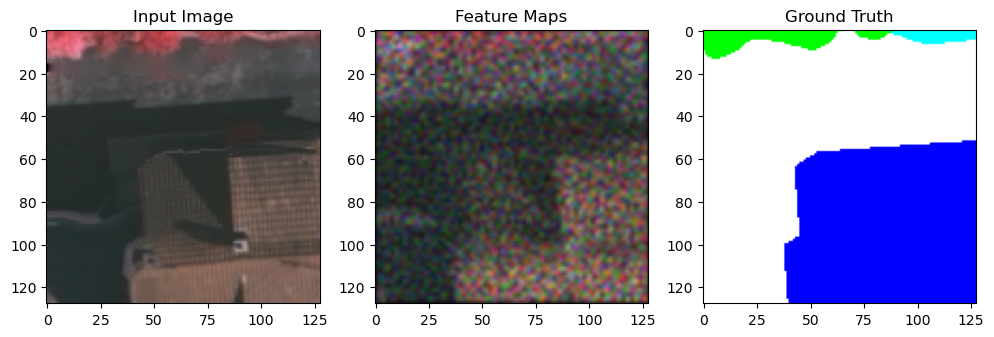

Coordinates (x, y): (0, 1)
Input Image Pixel Value:	[184  76  86]
Ground Truth Pixel Value:	[  0 255   0]
Segmented Image Pixel Value:	[  0 255   0]


In [15]:
vegetation_color = [0, 255, 0]  # Green
non_vegetation_color = [0, 0, 255] # Blue

indexing = 1600
input_image = images_load[indexing]
ground_truth = ground_truths[indexing]
features_get = fe.extract(input_image)

# Preprocess the input image
input_image_reshaped = cv2.resize(input_image, (128, 128)) / 255.0
features = input_image_reshaped.reshape(-1, 3)  # Remove the transpose operation here

# Predict segmentation mask
predicted_mask = model_loaded.forward(features)
predicted_mask = predicted_mask.argmax(axis=1).reshape(128, 128)
segmented_image = np.zeros((128, 128, 3), dtype=np.uint8)

# Create segmented image
segmented_image[predicted_mask == 0] = non_vegetation_color
segmented_image[predicted_mask == 1] = vegetation_color

# Visualize input image, ground truth, and segmented image
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.imshow(input_image)
plt.title('Input Image')

plt.subplot(1, 3, 2)
plt.imshow(features_get)
plt.title('Feature Maps')

plt.subplot(1, 3, 3)
plt.imshow(ground_truth)
plt.title('Ground Truth')

# plt.subplot(1, 3, 3)
# plt.imshow(segmented_image)
# plt.title('Segmented Image')

plt.show()

# Function to compare pixel values at specific coordinates
def compare_pixels(x, y):
    input_pixel = input_image[y, x]
    ground_truth_pixel = ground_truth[y, x]
    segmented_pixel = segmented_image[y, x]
    
    print(f"Coordinates (x, y): ({x}, {y})")
    print(f"Input Image Pixel Value:\t{input_pixel}")
    print(f"Ground Truth Pixel Value:\t{ground_truth_pixel}")
    print(f"Segmented Image Pixel Value:\t{segmented_pixel}")

# Example coordinates to compare
x, y = 0, 1  # Change this to any coordinate you want to check
compare_pixels(x, y)

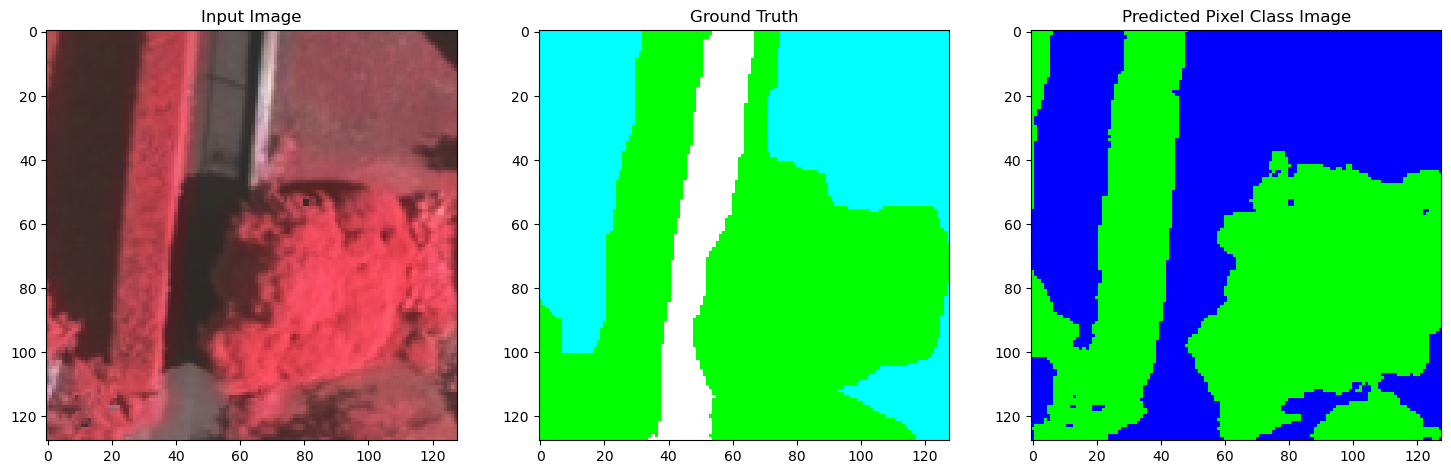

Pixel Class -> [0 255 0] = vegetation, [0 0 255] = non-vegetation
Coordinates (x, y):				(0, 0)
Input Image Pixel Value:			[185  81  85]
Prediction Values (non-vegetation, vegetation):	[0.05899952 0.94100048]
Class Prediction Image Pixel:			[  0 255   0]
Ground Truth Pixel Value:			[  0 255 255]


In [16]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Define colors for segmentation
vegetation_color = [0, 255, 0]  # Green
non_vegetation_color = [0, 0, 255]  # Blue

# Index for the current image
indexing = 5
input_image = images_load[indexing]
ground_truth = ground_truths[indexing]
features_get = fe.extract(input_image)

# Preprocess the input image
input_image_reshaped = cv2.resize(input_image, (128, 128)) / 255.0
features = input_image_reshaped.reshape(-1, 3)

# Predict segmentation mask and capture the last layer's output
output_logits = model_loaded.forward(features)
predicted_mask = output_logits.argmax(axis=1).reshape(128, 128)
segmented_image = np.zeros((128, 128, 3), dtype=np.uint8)

# Create segmented image
segmented_image[predicted_mask == 0] = non_vegetation_color
segmented_image[predicted_mask == 1] = vegetation_color

# Visualize input image, ground truth, and segmented image
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(input_image)
plt.title('Input Image')

# plt.subplot(1, 4, 2)
# plt.imshow(features_get)
# plt.title('Feature Maps')

plt.subplot(1, 3, 2)
plt.imshow(ground_truth)
plt.title('Ground Truth')

plt.subplot(1, 3, 3)
plt.imshow(segmented_image)
plt.title('Predicted Pixel Class Image')

plt.show()

# Function to compare pixel values at specific coordinates and the raw prediction values
def compare_pixels(x, y):
    input_pixel = input_image[y, x]
    ground_truth_pixel = ground_truth[y, x]
    segmented_pixel = segmented_image[y, x]
    raw_prediction = output_logits[y * 128 + x]  # Get the raw prediction values

    print("Pixel Class -> [0 255 0] = vegetation, [0 0 255] = non-vegetation")
    print(f"Coordinates (x, y):\t\t\t\t({x}, {y})")
    print(f"Input Image Pixel Value:\t\t\t{input_pixel}")
    print(f"Prediction Values (non-vegetation, vegetation):\t{raw_prediction}")
    print(f"Class Prediction Image Pixel:\t\t\t{segmented_pixel}")
    print(f"Ground Truth Pixel Value:\t\t\t{ground_truth_pixel}")
    

# Example coordinates to compare
x, y = 0,0   # Change this to any coordinate you want to check
compare_pixels(x, y)

Total Pixels: 16384
Total vegetation pixels: 14588
Total non-vegetation pixels: 1796
Predicted Image:
Total Pixels: 16384
Total vegetation pixels: 8517
Total non-vegetation pixels: 7867


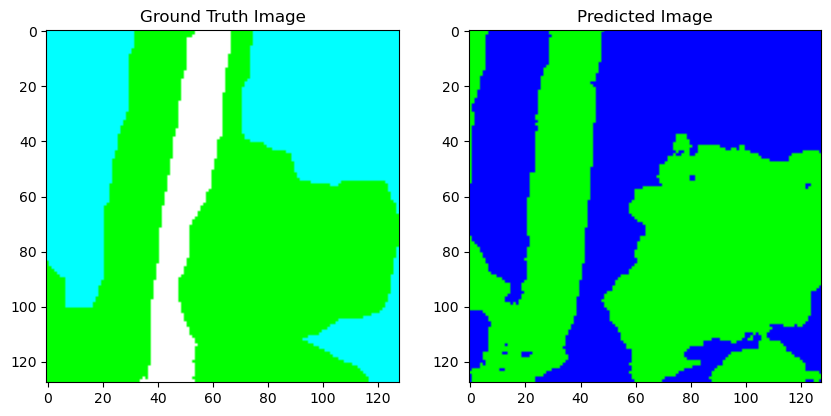

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Define color classes in BGR (OpenCV uses BGR by default)
vegetation_colors = [np.array([0, 255, 0]), np.array([0, 255, 255])]
non_vegetation_colors = [np.array([255, 255, 255]), np.array([255, 0, 0]), np.array([0, 0, 255]), np.array([255, 255, 0])]

# 5, 1506, 1602, 1813
# Load the ground truth image
index = 5
input_image = images_load[index]
ground_truth = ground_truths[index]
features_get = fe.extract(input_image)
ground_truth_image = ground_truth

# Initialize counters
vegetation_count = 0
non_vegetation_count = 0

# Check each pixel in the ground truth image
for y in range(ground_truth_image.shape[0]):
    for x in range(ground_truth_image.shape[1]):
        pixel = ground_truth_image[y, x]
        if any(np.array_equal(pixel, color) for color in vegetation_colors):
            vegetation_count += 1
        elif any(np.array_equal(pixel, color) for color in non_vegetation_colors):
            non_vegetation_count += 1

# Print the results
print("Total Pixels:", vegetation_count + non_vegetation_count)
print(f"Total vegetation pixels: {vegetation_count}")
print(f"Total non-vegetation pixels: {non_vegetation_count}")

# Preprocess the input image
input_image_reshaped = cv2.resize(input_image, (128, 128)) / 255.0
features = input_image_reshaped.reshape(-1, 3)  # Remove the transpose operation here

# Predict segmentation mask
predicted_mask = model_loaded.forward(features)
predicted_mask = predicted_mask.argmax(axis=1).reshape(128, 128)
segmented_image = np.zeros((128, 128, 3), dtype=np.uint8)

# Create segmented image
segmented_image[predicted_mask == 0] = non_vegetation_color
segmented_image[predicted_mask == 1] = vegetation_color

# Load the predicted image (assuming you have it as 'predicted_image')
predicted_image = segmented_image  # Replace with actual predicted image

# Initialize counters for predicted image
vegetation_count_pred = 0
non_vegetation_count_pred = 0

# Check each pixel in the predicted image
for y in range(predicted_image.shape[0]):
    for x in range(predicted_image.shape[1]):
        pixel = predicted_image[y, x]
        if any(np.array_equal(pixel, color) for color in vegetation_colors):
            vegetation_count_pred += 1
        elif any(np.array_equal(pixel, color) for color in non_vegetation_colors):
            non_vegetation_count_pred += 1

# Print the predicted results
print("Predicted Image:")
print("Total Pixels:", vegetation_count_pred + non_vegetation_count_pred)
print(f"Total vegetation pixels: {vegetation_count_pred}")
print(f"Total non-vegetation pixels: {non_vegetation_count_pred}")

# Optionally, visualize the ground truth and predicted images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(ground_truth_image)
plt.title('Ground Truth Image')

plt.subplot(1, 2, 2)
plt.imshow(predicted_image)
plt.title('Predicted Image')

plt.show()

Ground Truth:
Total Pixels: 16384
Total vegetation pixels: 9250
Total non-vegetation pixels: 7134
Predicted Image:
Total Pixels: 16384
Total vegetation pixels: 8323
Total non-vegetation pixels: 8061

Comparison:
Difference in vegetation pixels: -927
Difference in non-vegetation pixels: 927


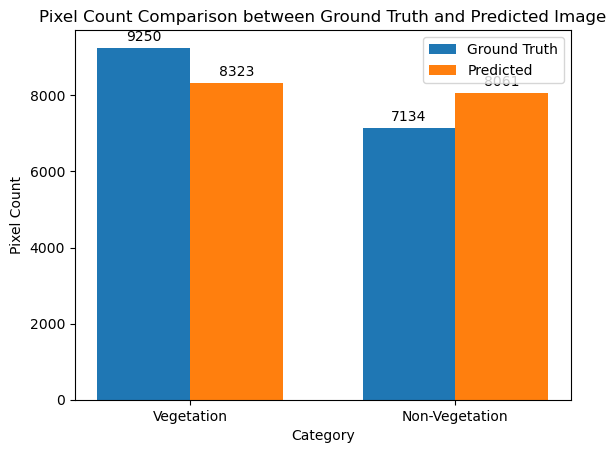

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Define color classes in BGR (OpenCV uses BGR by default)
vegetation_colors = [np.array([0, 255, 0]), np.array([0, 255, 255])]
non_vegetation_colors = [np.array([255, 255, 255]), np.array([255, 0, 0]), np.array([0, 0, 255]), np.array([255, 255, 0])]

# Example indices
indices = [5, 1506, 1602, 1813]

# Select the index
index = 1813

# Load the input image and ground truth
input_image = images_load[index]
ground_truth = ground_truths[index]

# Extract features
features_get = fe.extract(input_image)

# Initialize counters for the ground truth image
vegetation_count_gt = 0
non_vegetation_count_gt = 0

# Check each pixel in the ground truth image
for y in range(ground_truth.shape[0]):
    for x in range(ground_truth.shape[1]):
        pixel = ground_truth[y, x]
        if any(np.array_equal(pixel, color) for color in vegetation_colors):
            vegetation_count_gt += 1
        elif any(np.array_equal(pixel, color) for color in non_vegetation_colors):
            non_vegetation_count_gt += 1

# Print the ground truth results
print("Ground Truth:")
print("Total Pixels:", vegetation_count_gt + non_vegetation_count_gt)
print(f"Total vegetation pixels: {vegetation_count_gt}")
print(f"Total non-vegetation pixels: {non_vegetation_count_gt}")

# Preprocess the input image for the model
input_image_resized = cv2.resize(input_image, (128, 128)) / 255.0
features = input_image_resized.reshape(-1, 3)

# Predict segmentation mask
predicted_mask = model_loaded.forward(features)
predicted_mask = predicted_mask.argmax(axis=1).reshape(128, 128)

# Create segmented image
segmented_image = np.zeros((128, 128, 3), dtype=np.uint8)
segmented_image[predicted_mask == 0] = non_vegetation_colors[0]  # Assuming non-vegetation class 0
segmented_image[predicted_mask == 1] = vegetation_colors[0]  # Assuming vegetation class 1

# Initialize counters for the predicted image
vegetation_count_pred = 0
non_vegetation_count_pred = 0

# Check each pixel in the predicted image
for y in range(segmented_image.shape[0]):
    for x in range(segmented_image.shape[1]):
        pixel = segmented_image[y, x]
        if any(np.array_equal(pixel, color) for color in vegetation_colors):
            vegetation_count_pred += 1
        elif any(np.array_equal(pixel, color) for color in non_vegetation_colors):
            non_vegetation_count_pred += 1

# Print the predicted results
print("Predicted Image:")
print("Total Pixels:", vegetation_count_pred + non_vegetation_count_pred)
print(f"Total vegetation pixels: {vegetation_count_pred}")
print(f"Total non-vegetation pixels: {non_vegetation_count_pred}")

# Compare the results
print("\nComparison:")
print(f"Difference in vegetation pixels: {vegetation_count_pred - vegetation_count_gt}")
print(f"Difference in non-vegetation pixels: {non_vegetation_count_pred - non_vegetation_count_gt}")

# Visualization
categories = ['Vegetation', 'Non-Vegetation']
ground_truth_counts = [vegetation_count_gt, non_vegetation_count_gt]
predicted_counts = [vegetation_count_pred, non_vegetation_count_pred]

x = np.arange(len(categories))
width = 0.35

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, ground_truth_counts, width, label='Ground Truth')
bars2 = ax.bar(x + width/2, predicted_counts, width, label='Predicted')

ax.set_xlabel('Category')
ax.set_ylabel('Pixel Count')
ax.set_title('Pixel Count Comparison between Ground Truth and Predicted Image')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate('{}'.format(height),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.show()

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math

# Load images and ground truth labels
images_path = 'patching_fix/patch_image'
feature_images_path = 'patching_fix/feature_extract'
ground_truths_path = 'patching_fix/patch_ground'

images_load = dp.load_images_from_folder(images_path)
feature_images_load = dp.load_images_from_folder(feature_images_path)
ground_truths = dp.load_ground_truth_from_folder(ground_truths_path)

feature_images_train = feature_images_load[:math.ceil(len(feature_images_load)*0.7)] 
image_label_train = ground_truths[:math.ceil(len(ground_truths)*0.7)]

image_test = images_load[math.ceil(len(images_load)*0.7):]
image_label_test = ground_truths[math.ceil(len(ground_truths)*0.7):]

# Define color classes in BGR (OpenCV uses BGR by default)
vegetation_colors = [np.array([0, 255, 0]), np.array([0, 255, 255])]
non_vegetation_colors = [np.array([255, 255, 255]), np.array([255, 0, 0]), np.array([0, 0, 255]), np.array([255, 255, 0])]

# Initialize total counters for ground truth and predicted images
total_vegetation_count_gt = 0
total_non_vegetation_count_gt = 0
total_vegetation_count_pred = 0
total_non_vegetation_count_pred = 0

# Iterate through all images
for index in range(len(images_load)):
    # Load the input image and ground truth
    input_image = images_load[index]
    ground_truth = ground_truths[index]

    # Extract features
    features_get = fe.extract(input_image)

    # Initialize counters for the ground truth image
    vegetation_count_gt = 0
    non_vegetation_count_gt = 0

    # Check each pixel in the ground truth image
    for y in range(ground_truth.shape[0]):
        for x in range(ground_truth.shape[1]):
            pixel = ground_truth[y, x]
            if any(np.array_equal(pixel, color) for color in vegetation_colors):
                vegetation_count_gt += 1
            elif any(np.array_equal(pixel, color) for color in non_vegetation_colors):
                non_vegetation_count_gt += 1

    # Add to total counts
    total_vegetation_count_gt += vegetation_count_gt
    total_non_vegetation_count_gt += non_vegetation_count_gt

    # Preprocess the input image for the model
    input_image_resized = cv2.resize(input_image, (128, 128)) / 255.0
    features = input_image_resized.reshape(-1, 3)

    # Predict segmentation mask
    predicted_mask = model_loaded.forward(features)
    predicted_mask = predicted_mask.argmax(axis=1).reshape(128, 128)

    # Create segmented image
    segmented_image = np.zeros((128, 128, 3), dtype=np.uint8)
    segmented_image[predicted_mask == 0] = non_vegetation_colors[0]  # Assuming non-vegetation class 0
    segmented_image[predicted_mask == 1] = vegetation_colors[0]  # Assuming vegetation class 1

    # Initialize counters for the predicted image
    vegetation_count_pred = 0
    non_vegetation_count_pred = 0

    # Check each pixel in the predicted image
    for y in range(segmented_image.shape[0]):
        for x in range(segmented_image.shape[1]):
            pixel = segmented_image[y, x]
            if any(np.array_equal(pixel, color) for color in vegetation_colors):
                vegetation_count_pred += 1
            elif any(np.array_equal(pixel, color) for color in non_vegetation_colors):
                non_vegetation_count_pred += 1

    # Add to total counts
    total_vegetation_count_pred += vegetation_count_pred
    total_non_vegetation_count_pred += non_vegetation_count_pred

# Calculate total pixels in ground truth and predicted images
total_pixels_gt = total_vegetation_count_gt + total_non_vegetation_count_gt
total_pixels_pred = total_vegetation_count_pred + total_non_vegetation_count_pred

# Calculate distribution percentages
vegetation_percentage_gt = (total_vegetation_count_gt / total_pixels_gt) * 100
non_vegetation_percentage_gt = (total_non_vegetation_count_gt / total_pixels_gt) * 100
vegetation_percentage_pred = (total_vegetation_count_pred / total_pixels_pred) * 100
non_vegetation_percentage_pred = (total_non_vegetation_count_pred / total_pixels_pred) * 100

# Print the total results
print("Ground Truth:")
print("Total Pixels:", total_pixels_gt)
print(f"Total vegetation pixels: {total_vegetation_count_gt} ({vegetation_percentage_gt:.2f}%)")
print(f"Total non-vegetation pixels: {total_non_vegetation_count_gt} ({non_vegetation_percentage_gt:.2f}%)")

print("Predicted Image:")
print("Total Pixels:", total_pixels_pred)
print(f"Total vegetation pixels: {total_vegetation_count_pred} ({vegetation_percentage_pred:.2f}%)")
print(f"Total non-vegetation pixels: {total_non_vegetation_count_pred} ({non_vegetation_percentage_pred:.2f}%)")

Ground Truth:
Total Pixels: 41385984
Total vegetation pixels: 17036636 (41.17%)
Total non-vegetation pixels: 24349348 (58.83%)
Predicted Image:
Total Pixels: 41385984
Total vegetation pixels: 9793303 (23.66%)
Total non-vegetation pixels: 31592681 (76.34%)


Ground Truth:
Total Pixels: 41385984
Total vegetation pixels: 17036636 (41.17%)
Total non-vegetation pixels: 24349348 (58.83%)
Predicted Image:
Total Pixels: 41385984
Total vegetation pixels: 9793303 (23.66%)
Total non-vegetation pixels: 31592681 (76.34%)


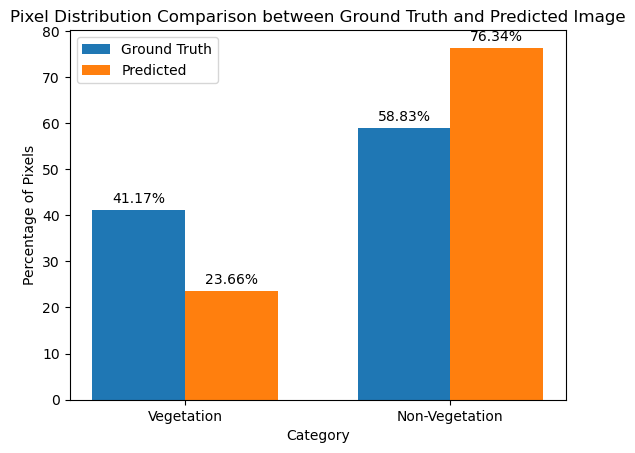

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Data from the previous calculations
total_pixels_gt = 41385984
total_vegetation_count_gt = 17036636 
total_non_vegetation_count_gt = 24349348 
vegetation_percentage_gt = (total_vegetation_count_gt / total_pixels_gt) * 100
non_vegetation_percentage_gt = (total_non_vegetation_count_gt / total_pixels_gt) * 100

total_pixels_pred = 41385984
total_vegetation_count_pred = 9793303 
total_non_vegetation_count_pred = 31592681 
vegetation_percentage_pred = (total_vegetation_count_pred / total_pixels_pred) * 100
non_vegetation_percentage_pred = (total_non_vegetation_count_pred / total_pixels_pred) * 100

# Print the total results
print("Ground Truth:")
print("Total Pixels:", total_pixels_gt)
print(f"Total vegetation pixels: {total_vegetation_count_gt} ({vegetation_percentage_gt:.2f}%)")
print(f"Total non-vegetation pixels: {total_non_vegetation_count_gt} ({non_vegetation_percentage_gt:.2f}%)")

print("Predicted Image:")
print("Total Pixels:", total_pixels_pred)
print(f"Total vegetation pixels: {total_vegetation_count_pred} ({vegetation_percentage_pred:.2f}%)")
print(f"Total non-vegetation pixels: {total_non_vegetation_count_pred} ({non_vegetation_percentage_pred:.2f}%)")

# Visualization
categories = ['Vegetation', 'Non-Vegetation']
ground_truth_counts = [vegetation_percentage_gt, non_vegetation_percentage_gt]
predicted_counts = [vegetation_percentage_pred, non_vegetation_percentage_pred]

x = np.arange(len(categories))
width = 0.35

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, ground_truth_counts, width, label='Ground Truth')
bars2 = ax.bar(x + width/2, predicted_counts, width, label='Predicted')

ax.set_xlabel('Category')
ax.set_ylabel('Percentage of Pixels')
ax.set_title('Pixel Distribution Comparison between Ground Truth and Predicted Image')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.show()

In [34]:
# vegetation_color = [0, 255, 0]  # Green
# non_vegetation_color = [0, 0, 255] # Blue

# # Initialize lists for TP, FP, FN, and IoU
# vegetation_TP = []
# vegetation_FP = []
# vegetation_FN = []
# non_vegetation_TP = []
# non_vegetation_FP = []
# non_vegetation_FN = []
# IoU_vegetation = []
# IoU_non_vegetation = []

# # Loop over testing images
# for i in range(len(image_test)):
#     # Reset counts for each image
#     TP_vegetation = 0
#     FP_vegetation = 0
#     FN_vegetation = 0
#     TP_non_vegetation = 0
#     FP_non_vegetation = 0
#     FN_non_vegetation = 0
    
#     input_image = image_test[i]
#     ground_truth = image_label_test[i]

#     # Preprocess the input image
#     input_image_reshaped = cv2.resize(input_image, (128, 128)) / 255.0
#     features = input_image_reshaped.reshape(-1, 3)

#     # Predict segmentation mask
#     predicted_mask = model_loaded.forward(features)
#     predicted_mask = predicted_mask.argmax(axis=1).reshape(128, 128)

#     # Convert ground truth to single-channel binary masks for vegetation and non-vegetation
#     vegetation_ground_truth = (ground_truth == [0, 255, 0]).all(axis=2)
#     non_vegetation_ground_truth = ~vegetation_ground_truth

#     # Iterate over each pixel in the patch
#     for y in range(128):
#         for x in range(128):
#             # Check if the pixel is vegetation in both prediction and ground truth
#             if vegetation_ground_truth[y, x] == 1 and predicted_mask[y, x] == 1:
#                 TP_vegetation += 1
#             # Check if the pixel is non-vegetation in both prediction and ground truth
#             elif non_vegetation_ground_truth[y, x] == 1 and predicted_mask[y, x] == 0:
#                 TP_non_vegetation += 1
#             # Check if the pixel is vegetation in ground truth but non-vegetation in prediction
#             elif vegetation_ground_truth[y, x] == 1 and predicted_mask[y, x] == 0:
#                 FN_vegetation += 1
#             # Check if the pixel is non-vegetation in ground truth but vegetation in prediction
#             elif non_vegetation_ground_truth[y, x] == 1 and predicted_mask[y, x] == 1:
#                 FP_non_vegetation += 1
                
#     # Append TP, FP, FN counts for both classes
#     vegetation_TP.append(TP_vegetation)
#     vegetation_FP.append(FP_vegetation)
#     vegetation_FN.append(FN_vegetation)
#     non_vegetation_TP.append(TP_non_vegetation)
#     non_vegetation_FP.append(FP_non_vegetation)
#     non_vegetation_FN.append(FN_non_vegetation)

#     # Calculate IoU for both classes if the denominator is not zero
#     if (TP_vegetation + FP_vegetation + FN_vegetation) != 0:
#         IoU_vegetation.append(TP_vegetation / (TP_vegetation + FP_vegetation + FN_vegetation))
#     else:
#         IoU_vegetation.append(0.0)

#     if (TP_non_vegetation + FP_non_vegetation + FN_non_vegetation) != 0:
#         IoU_non_vegetation.append(TP_non_vegetation / (TP_non_vegetation + FP_non_vegetation + FN_non_vegetation))
#     else:
#         IoU_non_vegetation.append(0.0)

#     print("===============================Image {}==================================".format(i+1))
#     print("vegetation_TP: {}, vegetation_FP: {}, vegetation_FN: {}\nnon_vegetation_TP: {}, non_vegetation_FP: {}, non_vegetation_FN: {}".format(TP_vegetation, FP_vegetation, FN_vegetation, TP_non_vegetation, FP_non_vegetation, FN_non_vegetation))
#     print("Vegetation IoU: {:.4f}, Non-Vegetation IoU: {:.4f}, Mean IoU: {:.4f}".format(IoU_vegetation[-1], IoU_non_vegetation[-1], (IoU_vegetation[-1] + IoU_non_vegetation[-1]) / 2))
#     # Visualize input image, ground truth, and segmented image
#     # plt.figure(figsize=(12, 5))
#     # plt.subplot(1, 3, 1)
#     # plt.imshow(input_image)
#     # plt.title('Input Image')
    
#     # plt.subplot(1, 3, 2)
#     # plt.imshow(ground_truth)
#     # plt.title('Ground Truth')
    
#     # # Create segmented image
#     # segmented_image = np.zeros((128, 128, 3), dtype=np.uint8)
#     # segmented_image[predicted_mask == 0] = non_vegetation_color
#     # segmented_image[predicted_mask == 1] = vegetation_color
    
#     # # print("Image {}: Vegetation IoU: {:.4f}, Non-Vegetation IoU: {:.4f}".format(i+1, IoU_vegetation[-1], IoU_non_vegetation[-1]))
#     # plt.subplot(1, 3, 3)
#     # plt.imshow(segmented_image)
#     # IoU = (IoU_vegetation[-1] + IoU_non_vegetation[-1]) / 2
#     # plt.title('Segmented Image (Mean IoU: {:.4f})'.format(IoU))
    
#     # plt.show()


In [36]:
# # Compute mean IoU across all images for vegetation and non-vegetation classes
# mean_IoU_vegetation_class = sum(IoU_vegetation) / len(IoU_vegetation)
# mean_IoU_non_vegetation_class = sum(IoU_non_vegetation) / len(IoU_non_vegetation)
# mean_IoU_overall = (mean_IoU_vegetation_class + mean_IoU_non_vegetation_class) / 2

# # Print mean IoU for both classes
# print("Mean IoU for Vegetation Class: {:.2f}".format(mean_IoU_vegetation_class * 100), "%")
# print("Mean IoU for Non-Vegetation Class: {:.2f}".format(mean_IoU_non_vegetation_class * 100), "%")
# print("Mean IoU Overall: {:.2f}".format(mean_IoU_overall * 100), "%")